<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/bnn_hierarchical_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Illustration of hierarchial Bayesian neural network classifiers.
Code and text is taken directly from [This blog post](https://twiecki.io/blog/2018/08/13/hierarchical_bayesian_neural_network/) by Thomas Wiecki.
(Reproduced with permission.)
[Original PyMC3 Notebook](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network_hierarchical.ipynb). Converted to Numpyro by Aleyna Kara (@karalleyna).


In [1]:
pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [2]:
import arviz as az

In [3]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from scipy import stats
import seaborn as sns
from warnings import filterwarnings

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

filterwarnings('ignore')
sns.set_style('white')

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

layer_names = ['w1_c', 'w2_c', 'w3_c']

The data set we are using are our battle tested half-moons as it is simple, non-linear and leads to pretty visualizations. This is what it looks like:

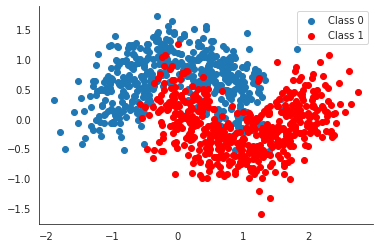

In [4]:
X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); plt.legend();

This is just to illustrate what the data generating distribution looks like, we will use way fewer data points, and create different subsets with different rotations.

In [5]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)
    
    return np.asarray(X)

In [6]:
np.random.seed(31)

n_samples = 100
n_grps = 18
n_grps_sq = int(np.sqrt(n_grps))
Xs, Ys = [], []
for i in range(n_grps):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)
    
    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)

In [7]:
Xs = np.stack(Xs)
Ys = np.stack(Ys)

Xs_train = Xs[:, :n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2:, :]
Ys_train = Ys[:, :n_samples // 2]
Ys_test = Ys[:, n_samples // 2:]

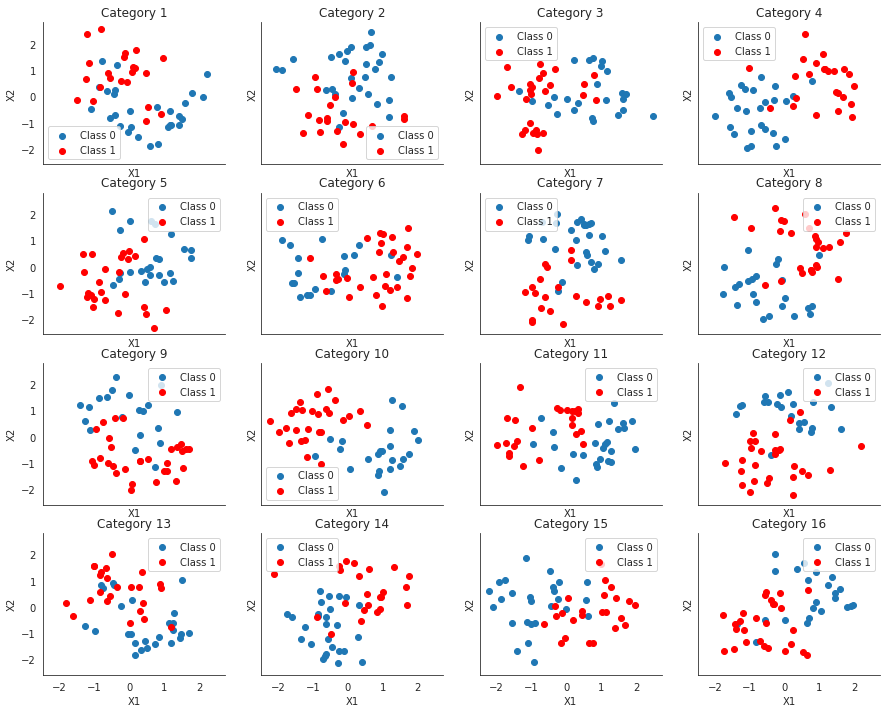

In [8]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
    ax.set(title='Category {}'.format(i + 1), xlabel='X1', ylabel='X2')

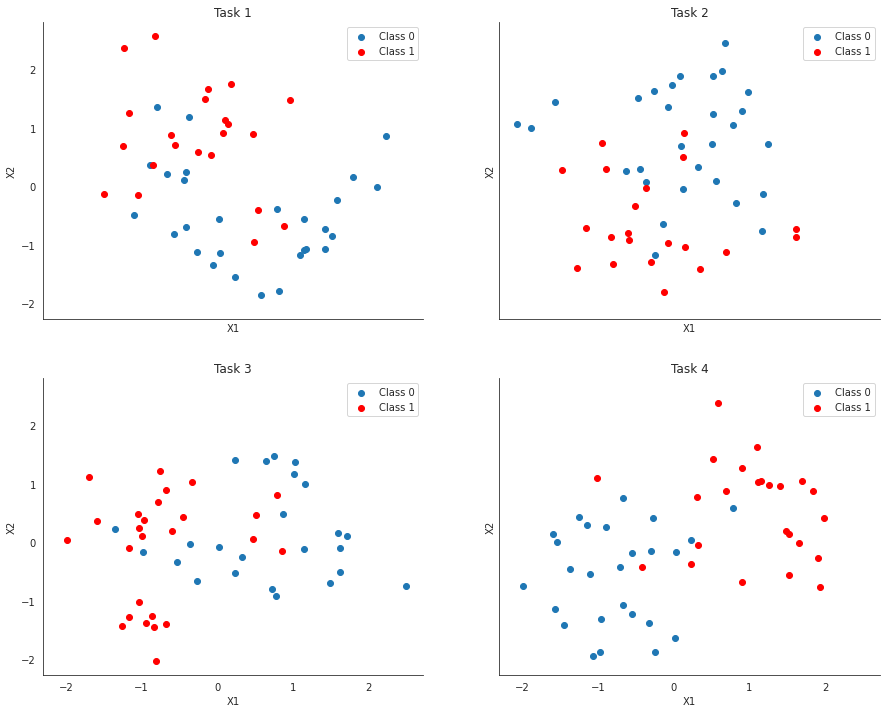

In [9]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=2, ncols=2, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
    ax.set(title='Task {}'.format(i + 1), xlabel='X1', ylabel='X2')

As you can see, we have 18 categories that share a higher-order structure (the half-moons). However, in the pure data space, no single classifier will be able to do a good job here. Also, because we only have 50 data points in each class, a NN will likely have a hard time producing robust results. But let's actually test this.

## Classify each category separately

The code for the NN below is explained in my previous blog post on [Bayesian Deep Learning](https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/).

In [10]:
'''
A two-layer bayesian neural network with computational flow
given by D_X => D_H => D_H => D_Y where D_H is the number of
hidden units.
'''
def model(X, Y, D_H):
    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))  # D_X D_H
    z1 = jnp.tanh(jnp.matmul(X, w1))   # N D_H  <= first layer of activations

    # sample second layer
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    z2 = jnp.tanh(jnp.matmul(z1, w2))  # N D_H  <= second layer of activations
    
    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))  # D_H D_Y
    z3 = jnp.matmul(z2, w3) # N D_Y  <= output of the neural network
    
    # Bernoulli likelihood <= Binary classification
    Y = numpyro.sample("Y", dist.Bernoulli(logits=z3))if Y is None else numpyro.sample("Y", dist.Bernoulli(logits=z3), obs=Y[:, None])

In [11]:
def run_inference(model, rng_key, args, **kwargs):
  kernel = NUTS(model)
  mcmc = MCMC(kernel, num_warmup=args["num_warmup"], num_samples=args["num_samples"], num_chains=args["num_chains"], progress_bar=False)
  mcmc.run(rng_key, **kwargs)
  return mcmc

In [12]:
def get_predictions(model, rng_key, samples, X, D_H, args, bnn_kwargs):
  # helper function for prediction
  def predict(model, rng_key, samples, X, D_H, bnn_kwargs):
      model = handlers.substitute(handlers.seed(model, rng_key), samples)
      # note that Y will be sampled in the model because we pass Y=None here
      model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H) if bnn_kwargs is None else handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H, **bnn_kwargs)
      return model_trace['Y']['value']

  # predict Y at inputs X
  vmap_args = (samples, random.split(rng_key, args['num_samples']*args['num_chains']))
  predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X, D_H, bnn_kwargs))(*vmap_args)
  return predictions

In [13]:
def get_mean_predictions(predictions, threshold=0.5):
  predictions = predictions[..., 0]
  # compute mean prediction and confidence interval around median
  mean_prediction = jnp.mean(predictions, axis=0)
  return mean_prediction > threshold

In [14]:
def fit_and_eval(model, X_train, X_test, Y_train, Y_test, grid, D_H, args, bnn_kwargs=None):
  # values to be returned
  pred_train, pred_test, pred_grid = [], [], []

  # do inference
  kwargs = {"X": X_train, "Y": Y_train, "D_H": D_H}
  if bnn_kwargs:
    kwargs = {**kwargs, **bnn_kwargs}

  rng_key, rng_key_train, rng_key_test, rng_key_grid = random.split(random.PRNGKey(0), 4)
  mcmc = run_inference(model, rng_key, args, **kwargs)
  samples = mcmc.get_samples()
  
  # predict Y_train and Y_test at inputs X_traind and X_test, respectively
  predictions = get_predictions(model, rng_key_train, samples, X_train, D_H, args, bnn_kwargs)
  mean_prediction = get_mean_predictions(predictions)
  pred_train = mean_prediction
  
  predictions = get_predictions(model, rng_key_test, samples, X_test, D_H,  args, bnn_kwargs)
  mean_prediction = get_mean_predictions(predictions)
  pred_test = mean_prediction


  ppc_grid = get_predictions(model, rng_key_grid, samples, grid, D_H, args, bnn_kwargs)
  return pred_train, pred_test, ppc_grid, mcmc 

In [15]:
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
D_H = 5
args = {"num_samples": 500, "num_chains": 1, "num_warmup": 1000}

In [16]:
Ys_pred_train, Ys_pred_test, grid_eval= [], [], []

for X_train, Y_train, X_test, Y_test in zip(Xs_train, Ys_train, Xs_test, Ys_test): 
  pred_train, pred_test, ppc_grid, mcmc_flat = fit_and_eval(model, X_train, X_test, Y_train, Y_test, grid, D_H, args)
  Ys_pred_train.append(pred_train)
  Ys_pred_test.append(pred_test)
  grid_eval.append(ppc_grid)

In [17]:
Ys_pred_train = np.stack(Ys_pred_train)
Ys_pred_test = np.stack(Ys_pred_test)
ppc_grid_single = np.stack(grid_eval)

Next, we have our function to create the BNN, sample from it, and generate predicitions. You can skip this one.

Next, we loop over each category and fit a different BNN to each one. Each BNN has its own weights and there is no connection between them. But note that because we are Bayesians, we place priors on our weights. In this case these are standard normal priors that act as regularizers to keep our weights close to zero.
<img src='https://twiecki.github.io/downloads/notebooks/bnn_flat.png'>

We use NUTS sampling here because the hierarchical model further below has a more complex posterior (see [Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for an explanation) and I wanted the results to be comparable. All simulations in here work with ADVI as well but the results don't look quite as strong.

In [18]:
print ("Train accuracy = {:.2f}%".format(100*np.mean(Ys_pred_train == Ys_train)))

Train accuracy = 86.67%


In [19]:
print ("Test accuracy = {:.2f}%".format(100*np.mean(Ys_pred_test == Ys_test)))

Test accuracy = 83.56%


OK, that doesn't seem so bad. Now let's look at the decision surfaces -- i.e. what the classifier thinks about each point in the data space.

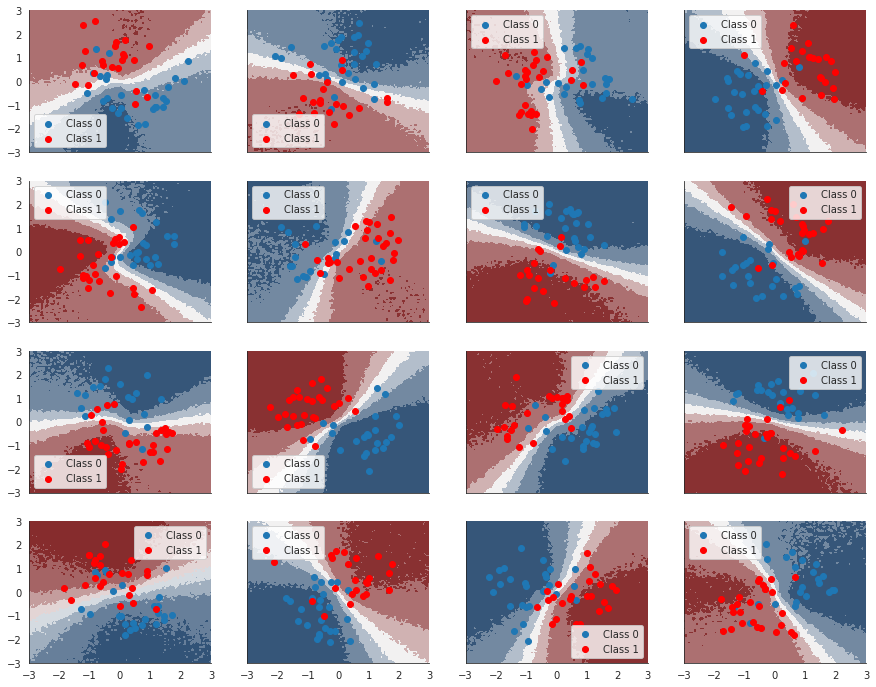

In [20]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape(100, 100), grid[:, 1].reshape(100, 100), ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

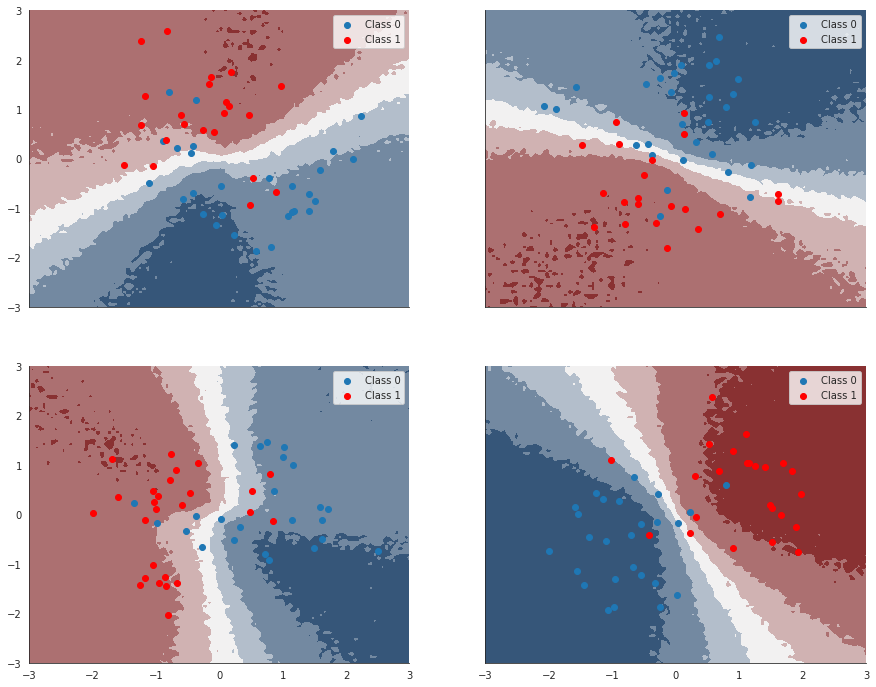

In [21]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=2, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape(100, 100), grid[:, 1].reshape(100, 100), ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

That doens't look all that convincing. We know from the data generation process as well as from the previous blog post [Bayesian Deep learning](https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) using the same data set that it give us a "Z"-shaped decision surface. So what happens is we don't have enough data to properly estimate the non-linearity in every category.

## Hierarchical Bayesian Neural Network

Can we do better? You bet!

It's actually quite straight-forward to turn this into one big hierarchical model for all categories, rather than many individual ones. Let's call the weight connecting neuron $i$ in layer 1 to neuron $j$ in layer 2 in category $c$ $w_{i, j, c}$ (I just omit the layer index for simplicity in notation). Rather than placing a fixed prior as we did above (i.e. $ w_{i, j, c} \sim \mathcal{N}(0, 1^2)$), we will assume that each weight comes from an overarching group distribution:
$ w_{i, j, c} \sim \mathcal{N}(\mu_{i, j}, \sigma^2)$. The key is that we will estimate $\mu_{i, j}$ and $\sigma$ simultaneously from data. 

<img src='https://twiecki.github.io/downloads/notebooks/bnn_hierarchical.png'>

Why not allow for different $\sigma_{i,j}^2$ per connection you might ask? Mainly just to make our life simpler and because it works well enough.

Note that we create a very rich model here. Every individual weight has its own hierarchical structure with a single group mean parameter and 16 per-category weights distributed around the group mean. While this creates a big amount of group distributions (as many as the flat NN had weights) there is no problem with this per-se, although it might be a bit unusual. One might argue that this model is quite complex and while that's true, in terms of degrees-of-freedom, this model is simpler than the unpooled one above (more on this below).

As for the code, we stack weights along a 3rd dimenson to get separate weights for each group. That way, through the power of broadcasting, the linear algebra works out almost the same as before.

In [43]:
'''
A two-layer bayesian neural network with computational flow
given by D_X => D_H => D_H => D_Y where D_H is the number of
hidden units.
'''
def hierarchical_nn(X, Y, D_H):
    D_C, _, D_X = X.shape
    D_Y = 1

    # Group mean distribution for input to hidden layer
    w1_c = numpyro.sample("w1_c", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))  # D_X D_H
    # Group standard-deviation
    w1_c_std = numpyro.sample("w1_c_std", dist.HalfNormal(1.))

    # sample second layer
    w2_c = numpyro.sample("w2_c", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    w2_c_std = numpyro.sample("w2_c_std", dist.HalfNormal(1.))
    
    # sample final layer of weights and neural network output
    w3_c = numpyro.sample("w3_c", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))  # D_H D_Y
    w3_c_std = numpyro.sample("w3_c_std", dist.HalfNormal(1.))

    w1_all = numpyro.sample("w1_all", dist.Normal(jnp.zeros((D_C, D_X, D_H)), jnp.ones((D_C, D_X, D_H))))  # D_C D_X D_H
    w2_all = numpyro.sample("w2_all", dist.Normal(jnp.zeros((D_C, D_H, D_H)), jnp.ones((D_C, D_H, D_H))))  # D_C D_H D_H
    w3_all = numpyro.sample("w3_all", dist.Normal(jnp.zeros((D_C, D_H, D_Y)), jnp.ones((D_C, D_H, D_Y))))  # D_C D_H D_Y
    
    w1 = w1_all * w1_c_std + w1_c
    w2 = w2_all * w2_c_std + w2_c
    w3 = w3_all * w3_c_std + w3_c

    z1 = jnp.tanh(jnp.matmul(X, w1))   # D_C N D_H  <= first layer of activations    
    z2 = jnp.tanh(jnp.matmul(z1, w2))  # D_C N D_H  <= second layer of activations
    z3 = jnp.matmul(z2, w3) # D_C N D_Y  <= output of the neural network

    # Bernoulli likelihood <= Binary classification
    Y = numpyro.sample("Y", dist.Bernoulli(logits=z3), obs=Y.reshape((18, -1, 1)) if Y is not None else Y)

In [44]:
# do inference
D_H = 5
# samples are 4000
args = {"num_samples": 500, "num_chains": 1, "num_warmup": 1000}
grid_3d = np.repeat(grid[None, ...], n_grps, axis=0)

In [45]:
Ys_hierarchical_pred_train, Ys_hierarchical_pred_test, ppc_grid, mcmc_hier  =\
                            fit_and_eval(hierarchical_nn, Xs_train, Xs_test, Ys_train, Ys_test, grid_3d, D_H, args)
trace_hier = mcmc_hier.get_samples()

In [46]:
print('Train accuracy = {:.2f}%'.format(100*np.mean(Ys_hierarchical_pred_train == Ys_train)))

Train accuracy = 90.78%


In [47]:
print('Test accuracy = {:.2f}%'.format(100*np.mean(Ys_hierarchical_pred_test == Ys_test)))

Test accuracy = 89.33%


Great -- we get higher train *and* test accuracy. Let's look at what the classifier has learned for each category.

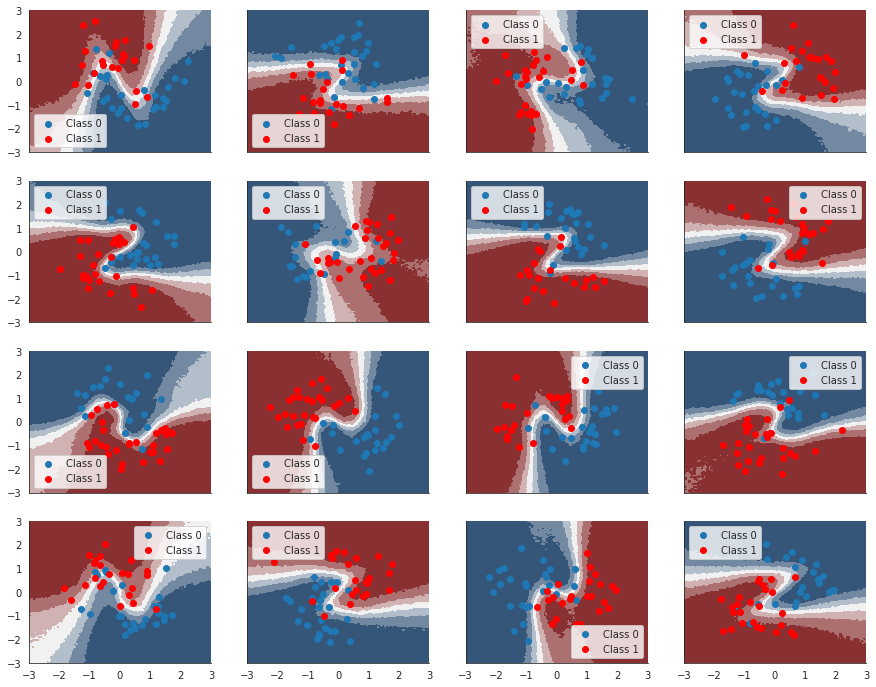

In [48]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid[:, i, :].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

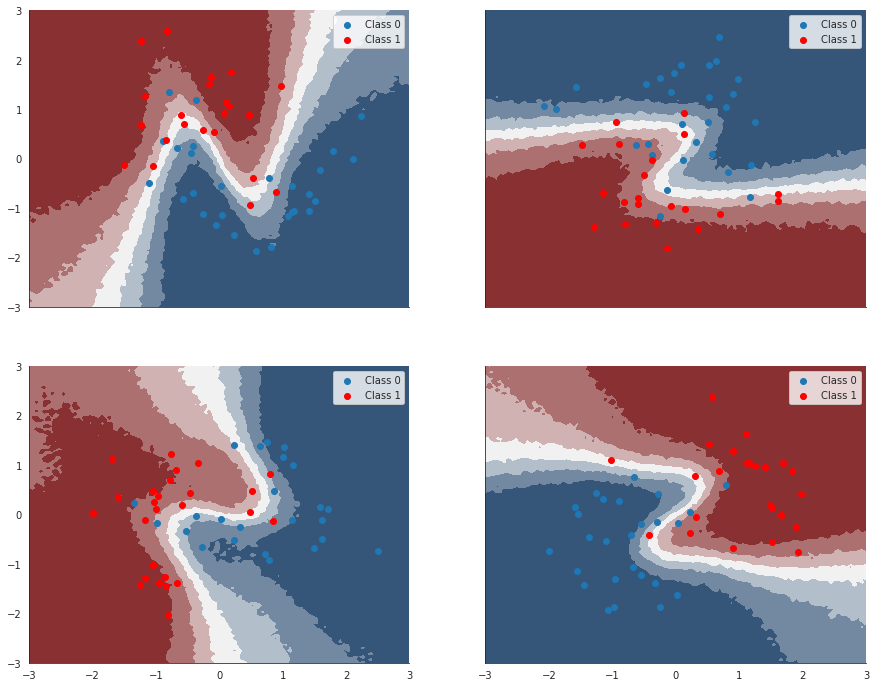

In [49]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=2, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid[:, i, :].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
plt.show()

Awesome! By (partially) pooling the data for each individual category we actually manage to retrieve the non-linearity. This is the strength of hierarchical models: we model the similarities of individual categories *and* their differences, sharing statistical power to the degree it's useful.

Of course, as we are in a Bayesian framework we also get the uncertainty estimate in our predictions:

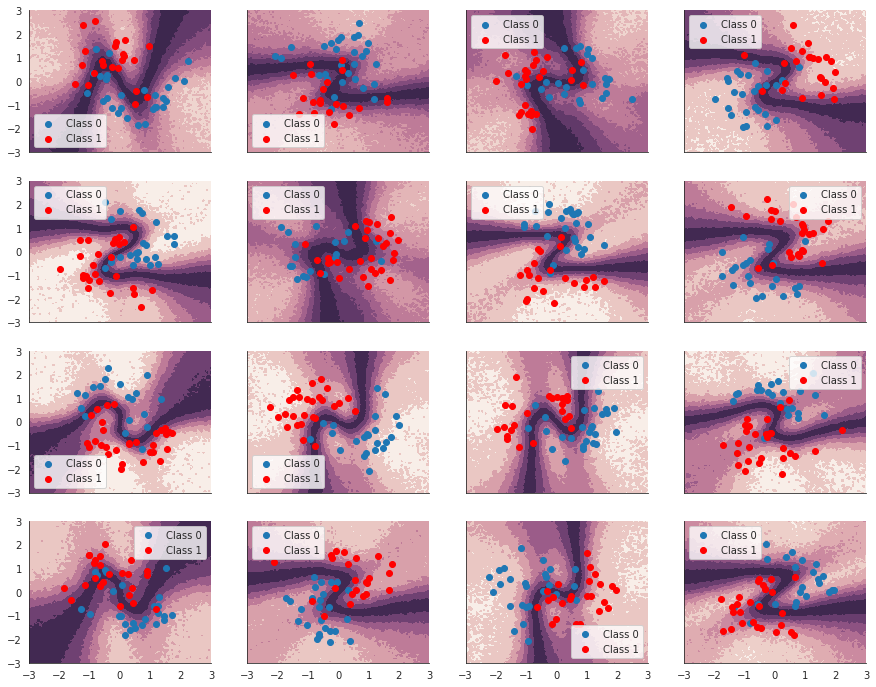

In [50]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape((100,-1)), grid[:, 1].reshape((100,-1)), ppc_grid[:, i, :].std(axis=0).reshape(100, 100), 
                          cmap=cmap_uncertainty)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

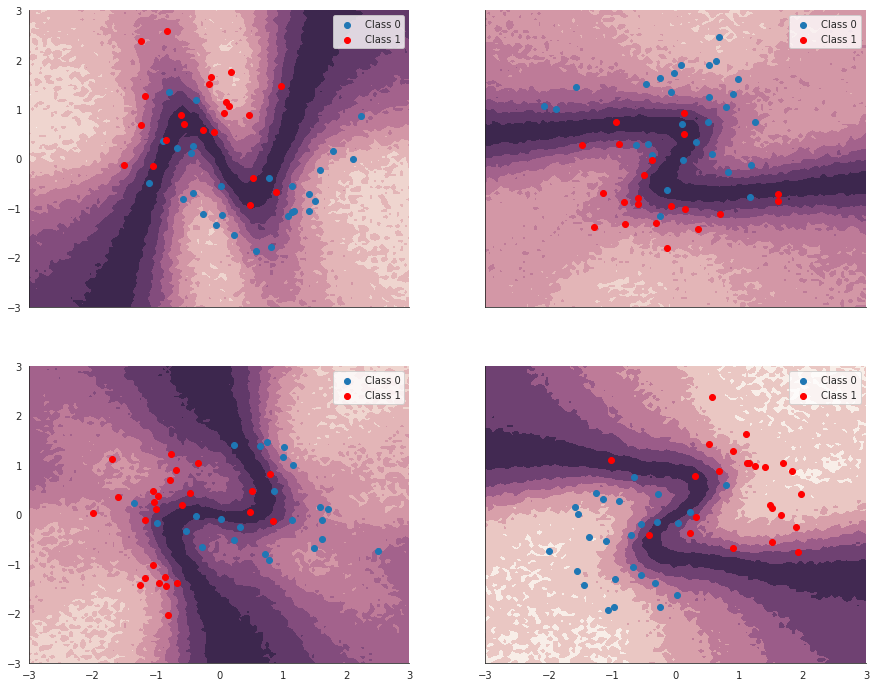

In [51]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=2, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape((100,-1)), grid[:, 1].reshape((100,-1)), ppc_grid[:, i, :].std(axis=0).reshape(100, 100), 
                          cmap=cmap_uncertainty)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

## Further analysis

There are a couple of things we might ask at this point. For example, how much does each layer specialize its weight per category. To answer this we can look at the group standard-deviation which informs us how much each weight is allowed to deviate from its group mean.

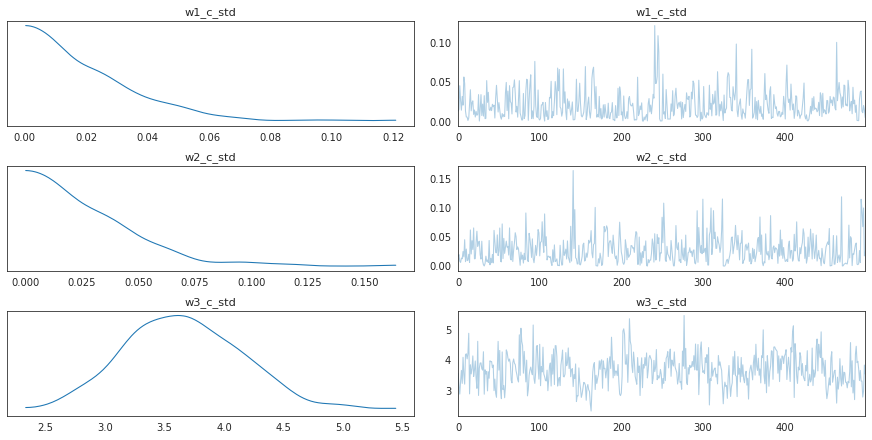

In [31]:
inference_data = az.from_numpyro(mcmc_hier)
az.plot_trace(inference_data, var_names=['w1_c_std', 'w2_c_std', 'w3_c_std']);

Interestingly, it seems that the specialization of the individual category sub-models is happening at the last layer where weights change most strongly from their group mean (as group variance is highest). I had assumed that this would happen at the first layer, based on what I found in my earlier blog post [Random-Walk Bayesian Deep Networks: Dealing with Non-Stationary Data](https://twiecki.github.io/blog/2017/03/14/random-walk-deep-net/) where the first layer acted as a rotation-layer.

Another interesting property of hierarchical models reveals itself here. As the group standard deviation is small for the weights in layers 1 and 2, it means these weights will be close to their group mean, reducing the effective number of parameters (degrees of freedom) of this model. This is different from the separate models where no similarities could be exploited to reduce the effective number of parameters. So from this perspective, the hierarchical model is simpler than the sum of the separate ones above. 

Finally, I wondered what the group-model actually learned. To get at that, we can use the trace of $\mu_{i,j}$ from the hierarchical model and pass it to the non-hierarchical model as if we trained these weights directly on a single data set. 

In [32]:
rng_key = random.PRNGKey(0)
args = {"num_samples": 500, "num_chains": 1, "num_warmup": 1000}
trace_flat = {}
 
trace_flat['w1'] = trace_hier['w1_c']
trace_flat['w2'] = trace_hier['w2_c']
trace_flat['w3'] = trace_hier['w3_c']

ppc_grid_hier2 = get_predictions(model, rng_key, trace_flat, grid, D_H, args, None)

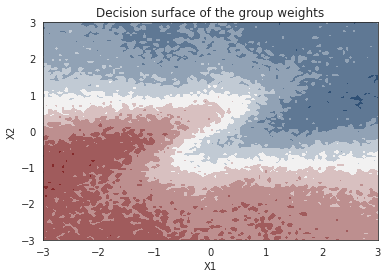

In [33]:
contour = plt.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid_hier2.mean(axis=0).reshape((100, 100)), cmap=cmap)
plt.xlabel('X1'); plt.ylabel('X2'); plt.title('Decision surface of the group weights');

It seems like the group model is representing the Z-shape in a fairly noisy way, which makes sense because the decision surface for every sub-model looks quite different.

### Correlations between weights

Usually we estimate NNs with MLE and BNNs with mean-field variational inference (like ADVI) which both ignore correlations between weights. As we used NUTS here, I was curious if there are meaningful correlations. Here, we look at the correlations in the first layer of the group distribution.

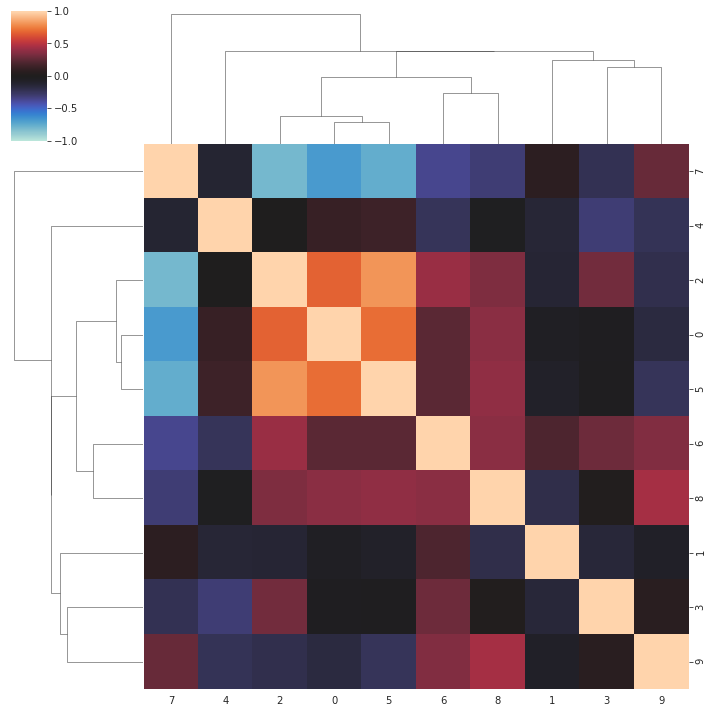

In [34]:
sns.clustermap(np.corrcoef(trace_hier[layer_names[0]].reshape((trace_hier[layer_names[0]].shape[0], -1)).T), 
               vmin=-1, center=0, vmax=1)

It indeed seems like point or mean-field estimates miss a lot of higher-order structure.

## Informative priors for Bayesian Neural Networks

Informative priors are a powerful concept in Bayesian modeling. Any expert information you encode in your priors can greatly increase your inference.

The same should hold true for BNNs but it raises the question how we can define informative priors over weights which exist in this abstract space that is very difficult to reason about (understanding the learned representations of neural networks is an active research topic).

While I don't know how to answer that generally, we can nonetheless explore this question with the techniques we developed this far. The group distributions from our hierarchical model are providing structured regularization for the subnetworks. But there is no reason we can't use the group distributions only in a hierarchical network. We can just use the inferred group structure and reapply it in the form of informative priors to individual, flat networks.

For this, we must first estimate the group distribution as it looks to the subnetworks. The easiest approach is to draw sample $l$ from the group posterior distributions ($\mu_l$ and $\sigma_l$) and, using this sample, draw realizations $x$ from the resulting distribution: $x \sim \mathcal{N}(\mu_l, \sigma_l^2)$. This is essentially sampling from the group posterior predictive distribution.

In [35]:
from collections import defaultdict
samples_tmp = defaultdict(list)
samples = {}

for layer_name in layer_names:
    for mu, std in zip(trace_hier[layer_name],trace_hier[f'{layer_name}_std']):
        for _ in range(20): # not sure why the `size` kwarg doesn't work
            samples_tmp[layer_name].append(stats.norm(mu, std).rvs())
    samples[layer_name] = np.asarray(samples_tmp[layer_name])

While there is no guarantee that this distribution is normal (technically it is a mixture of normals so could look much more like a Student-T), this is a good enough approximation in this case. As the correlation structure of the group distributions seem to play a key role as we've seen above, we use MultivariateNormal priors.

Note that this code just creates a single, non-hierarchical BNN.

In [36]:
from scipy.stats import multivariate_normal

'''
A two-layer bayesian neural network with computational flow
given by D_X => D_H => D_H => D_Y where D_H is the number of
hidden units.
'''
def construct_flat_prior_nn(X, Y, D_H, prior1_mu, prior1_cov, prior2_mu, prior2_cov, prior3_mu, prior3_cov):
    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.continuous.MultivariateNormal(prior1_mu.flatten(), prior1_cov)).reshape((D_X, D_H))  # D_X D_H
    z1 = jnp.tanh(jnp.matmul(X, w1))   # N D_H  <= first layer of activations
    # sample second layer
    w2 = numpyro.sample("w2", dist.continuous.MultivariateNormal(prior2_mu.flatten(), prior2_cov)).reshape((D_H, D_H))  # D_H D_H
    z2 = jnp.tanh(jnp.matmul(z1, w2))  # N D_H  <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", dist.continuous.MultivariateNormal(prior3_mu.flatten(), prior3_cov)).reshape((D_H, D_Y)) # D_H D_Y
    z3 = jnp.matmul(z2, w3) # N D_Y  <= output of the neural network
    
    # Bernoulli likelihood <= Binary classification
    Y = numpyro.sample("Y", dist.Bernoulli(logits=z3), obs=Y[:, None] if Y is not None else None)

Again, we just loop over the categories in our data set and create a separate BNN for each one. This is identical to our first attempt above, however, now we are setting the prior estimated from our group posterior of our hierarchical model in our second approach.

In [37]:
Ys_pred_train = []
Ys_pred_test = []
grid_eval = []

Ys_pred_train, Ys_pred_test, grid_eval= [], [], []

for X_train, Y_train, X_test, Y_test in zip(Xs_train, Ys_train, Xs_test, Ys_test): 
  n_samples = samples['w1_c'].shape[0]
  # Construct informative priors from previous hierarchical posterior
  bnn_kwargs = dict(prior1_mu=samples['w1_c'].mean(axis=0),
        prior1_cov=np.cov(samples['w1_c'].reshape((n_samples, -1)).T),
        prior2_mu=samples['w2_c'].mean(axis=0),
        prior2_cov=np.cov(samples['w2_c'].reshape((n_samples, -1)).T),
        prior3_mu=samples['w3_c'].mean(axis=0),
        prior3_cov=np.cov(samples['w3_c'].reshape((n_samples, -1)).T))
  pred_train, pred_test, ppc_grid, mcmc_flat = fit_and_eval(construct_flat_prior_nn, X_train, X_test, Y_train, Y_test, grid, D_H, args, bnn_kwargs)
  Ys_pred_train.append(pred_train)
  Ys_pred_test.append(pred_test)
  grid_eval.append(ppc_grid)

    
Ys_pred_train.append(pred_train)
Ys_pred_test.append(pred_test)
grid_eval.append(ppc_grid)

In [38]:
Ys_info_pred_train = np.asarray(Ys_pred_train)
Ys_info_pred_test = np.asarray(Ys_pred_test)
grid_eval = np.asarray(grid_eval)

**Drum roll**

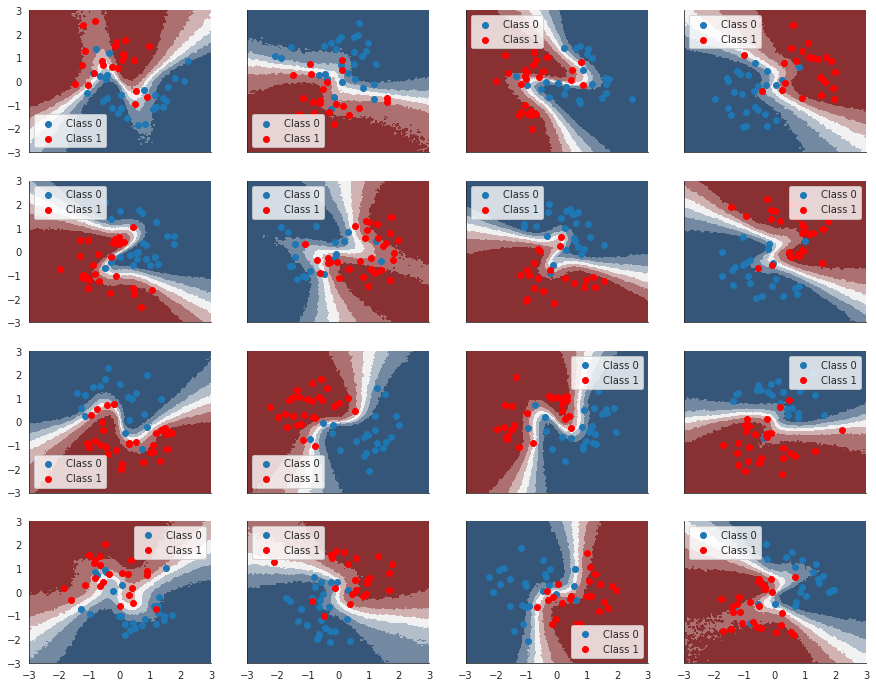

In [39]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), grid_eval[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

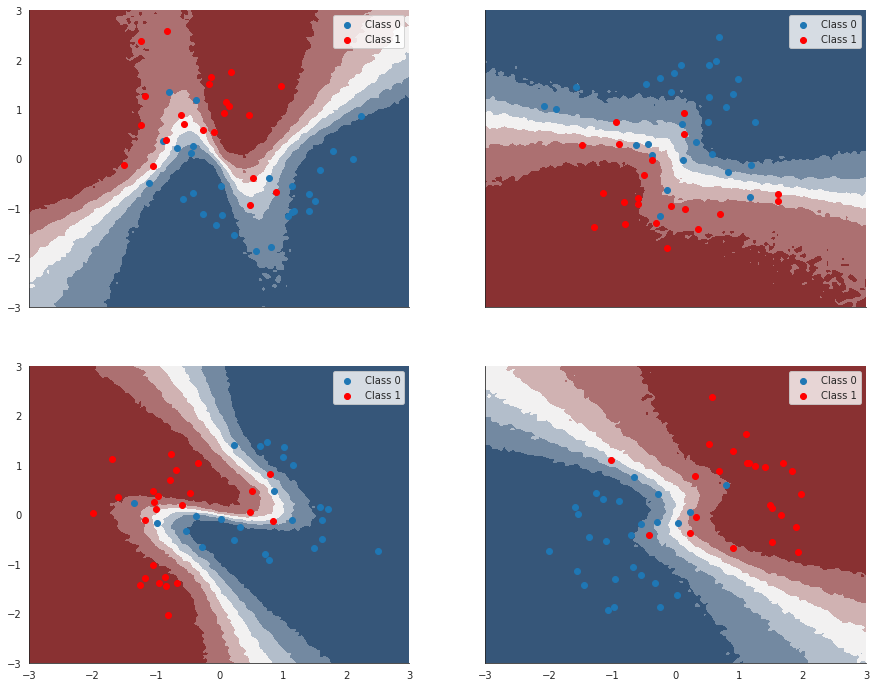

In [40]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=2, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), grid_eval[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

In [41]:
print('Train accuracy = {:.2f}%'.format(100*np.mean(Ys_info_pred_train[:-1,:] == Ys_train)))

Train accuracy = 91.44%


In [42]:
print('Test accuracy = {:.2f}%'.format(100*np.mean(Ys_info_pred_test[:-1,:] == Ys_test)))

Test accuracy = 86.67%


Holy mackerel, it actually worked!

As demonstrated, informed priors can help NNs a lot. But what if we don't have hierarchical structure or it would be too expensive to estimate? We could attempt to construct priors by deriving them from pre-trained models. For example, if I wanted to train an object recognition model to my own custom categories, I could start with a model like ResNet trained on the CIFAR data set, derive priors from the weights, and then train a new model on my custom data set which could then get by with fewer images than if we trained from scratch.
